# Parsing PDF documents for RAG applications

This notebook shows how to leverage GPT-4V to turn rich PDF documents such as slide decks or exports from web pages into usable content for your RAG application.

This technique can be used if you have a lot of unstructured data containing valuable information that you want to be able to retrieve as part of your RAG pipeline.

For example, you could build a Knowledge Assistant that could answer user queries about your company or product based on information contained in PDF documents. 

The example documents used in this notebook are located at [data/example_pdfs](data/example_pdfs). They are related to OpenAI's APIs and various techniques that can be used as part of LLM projects.

## Data preparation

In this section, we will process our input data to prepare it for retrieval.

We will do this in 2 ways:

1. Extracting text with pdfminer
2. Converting the PDF pages to images to analyze them with GPT-4V

You can skip the 1st method if you want to only use the content inferred from the image analysis.

### Setup

We need to install a few libraries to convert the PDF to images and extract the text (optional).

**Note: You need to install `poppler` on your machine for the `pdf2image` library to work. You can follow the instructions to install it [here](https://pypi.org/project/pdf2image/).**

In [2]:
import os
import json
import requests
import time
from openai import AzureOpenAI

# Make sure to set environment variables, or directly pass the values below
# azure_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT")  # Get the endpoint from environment variables
# api_key = os.getenv("AZURE_OPENAI_API_KEY")  # Get the API key from environment variables

# Alternatively, if you're not using environment variables, pass the values directly
azure_endpoint = "https://aitraning4862165520.openai.azure.com/"
api_key = "b92d9f6b81364b5abebcd171cd479d26"

if not azure_endpoint or not api_key:
    raise ValueError("Azure endpoint or API key is not set.")

client = AzureOpenAI(
    azure_endpoint=azure_endpoint,
    api_key=api_key,
    api_version="2024-05-01-preview"
)

assistant = client.beta.assistants.create(
    model="gpt-4o",  # Replace with your actual model deployment name
    instructions="",
    tools=[{"type": "file_search"}],
    tool_resources={"file_search": {"vector_store_ids": ["vs_GswRocHbM1N8DzNIFwn24NXQ"]}},
    temperature=1,
    top_p=1
)


OpenAIError: Missing credentials. Please pass one of `api_key`, `azure_ad_token`, `azure_ad_token_provider`, or the `AZURE_OPENAI_API_KEY` or `AZURE_OPENAI_AD_TOKEN` environment variables.

In [3]:
# Imports
from pdf2image import convert_from_path
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)
from pdfminer.high_level import extract_text
import base64
from io import BytesIO
import os
import concurrent
from tqdm import tqdm
from openai import OpenAI
import re
import pandas as pd 
from sklearn.metrics.pairwise import cosine_similarity
import json
import numpy as np
from rich import print
from ast import literal_eval

### File processing

In [8]:
def convert_doc_to_images(path):
    poppler_path = r"C:\poppler-24.07.0\Library\bin"
    images = convert_from_path(path, poppler_path=poppler_path)
    return images

def extract_text_from_doc(path):
    text = extract_text(path)
    page_text = []
    return text

#### Testing with an example

In [9]:
file_path = "hmaids.pdf"

images = convert_doc_to_images(file_path)

In [10]:
text = extract_text_from_doc(file_path)

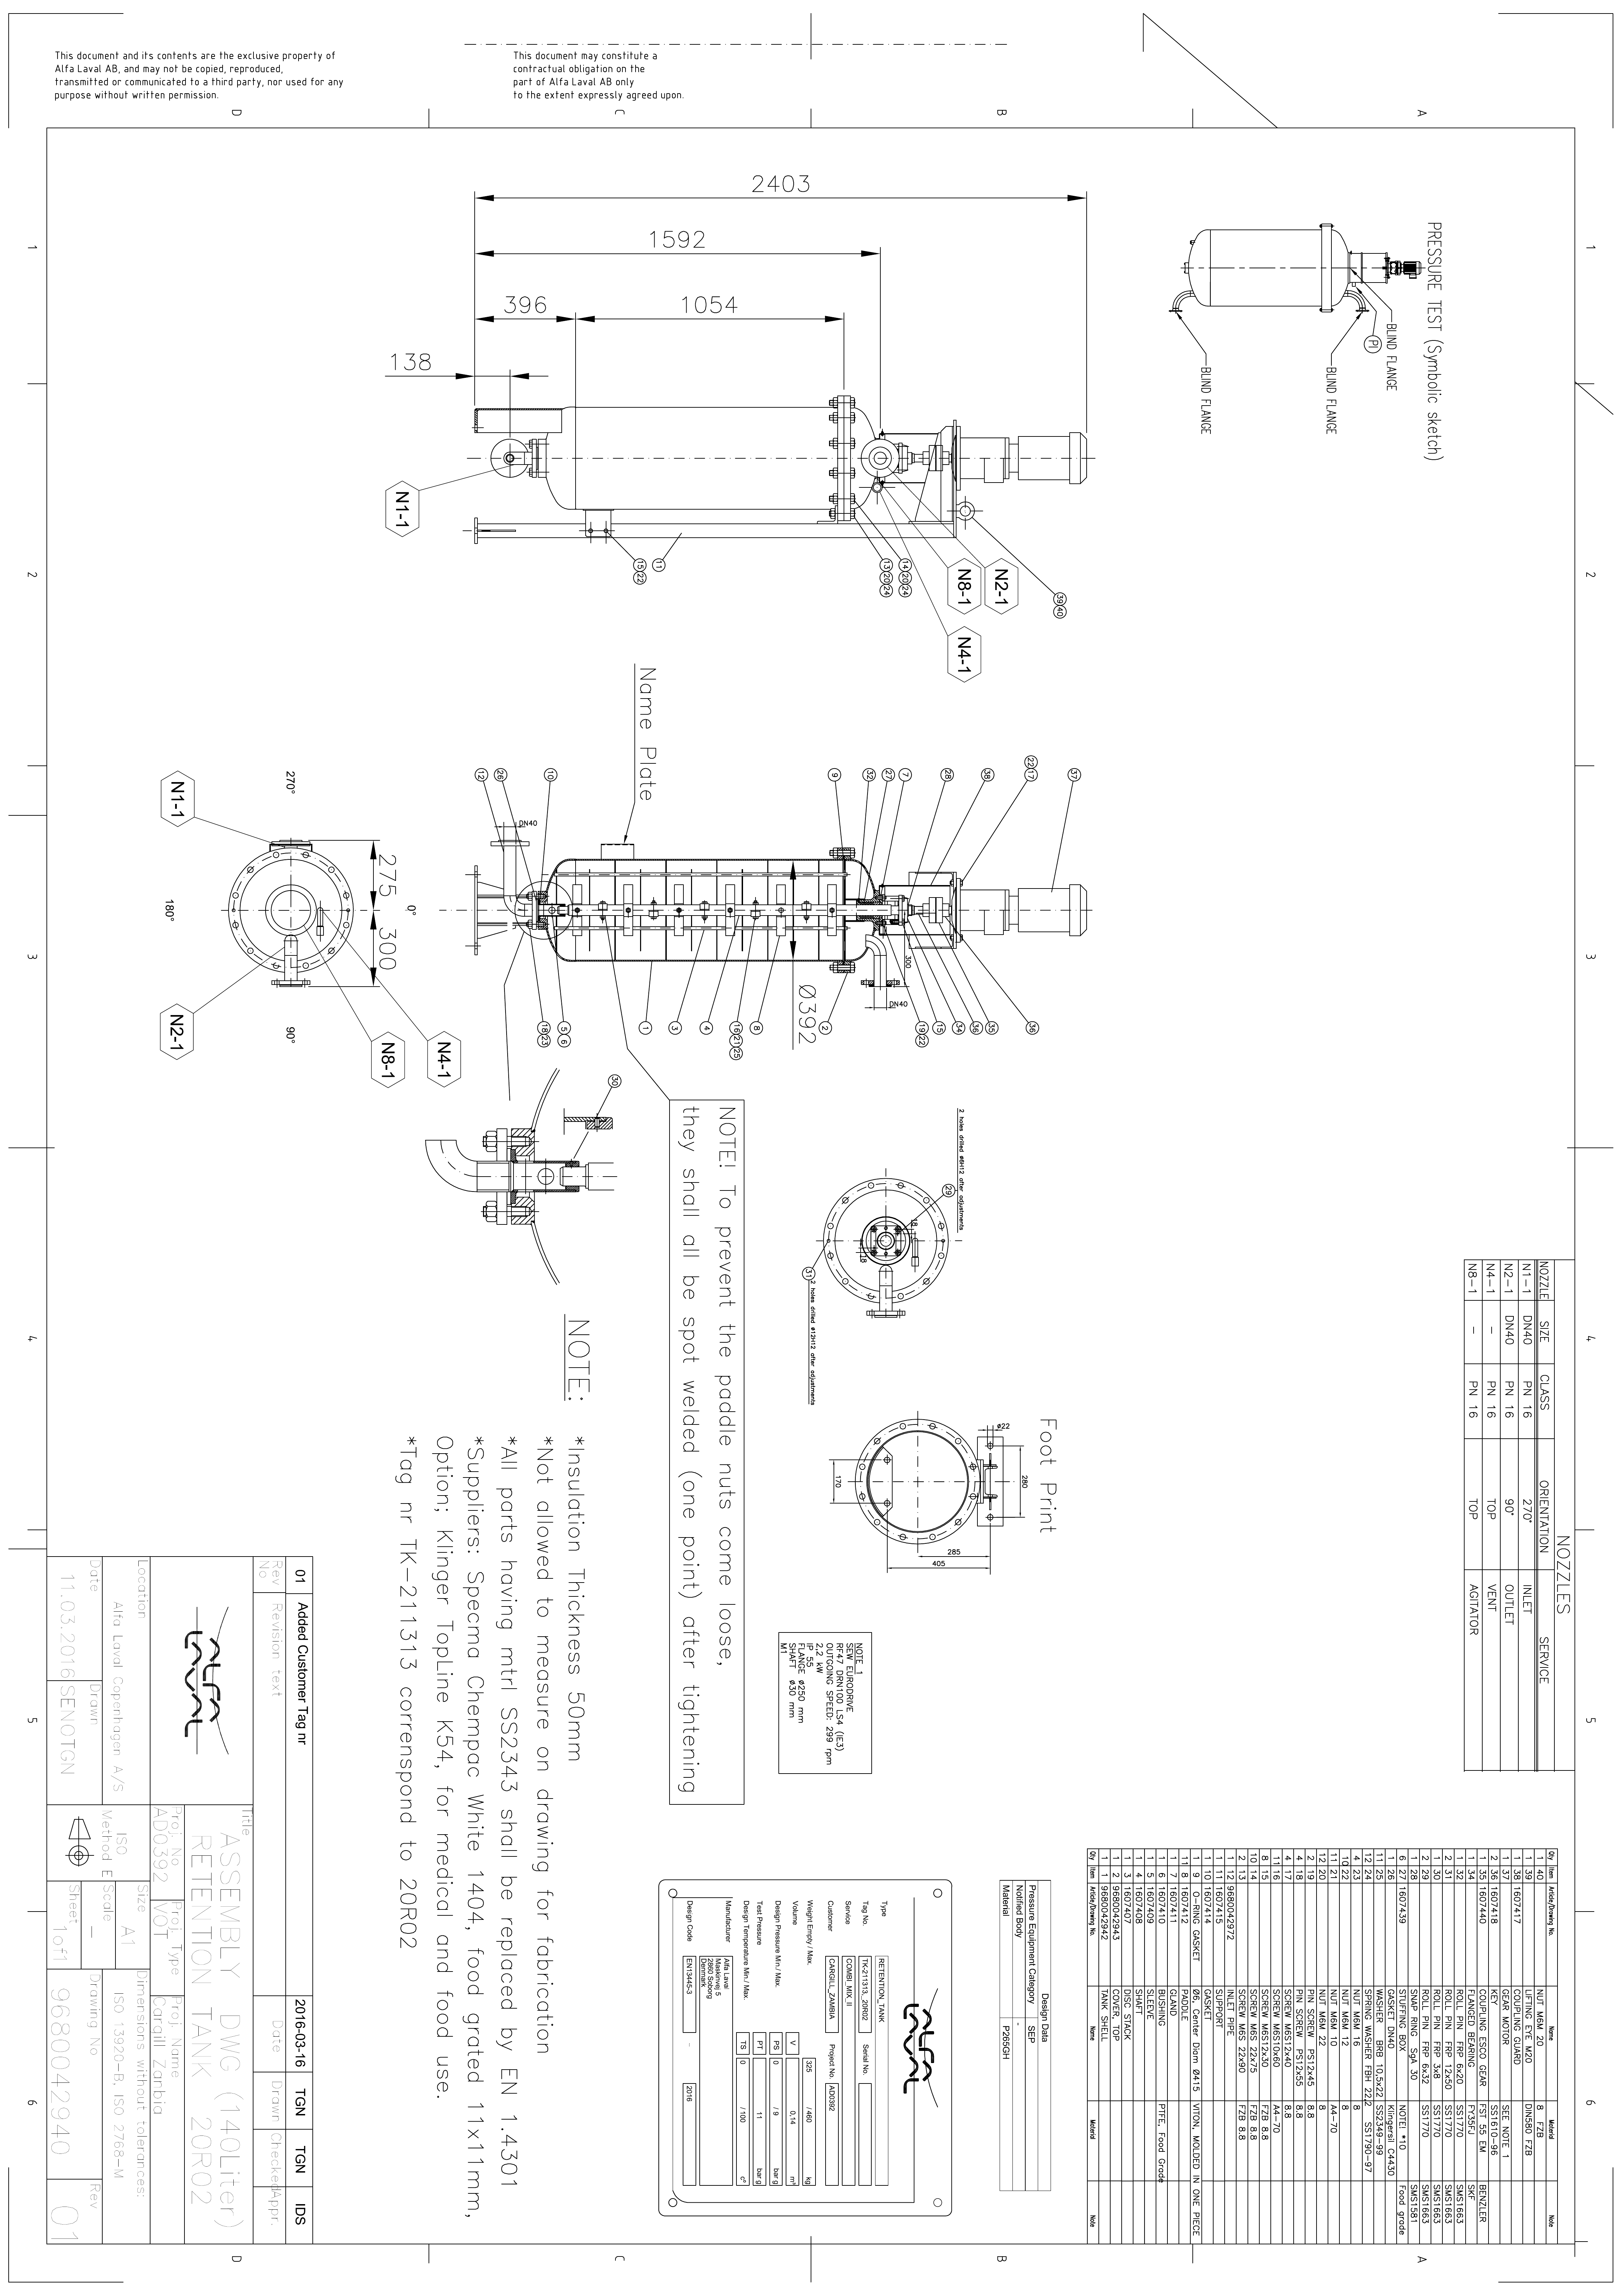

In [11]:
for img in images:
    display(img)

### Image analysis with GPT-4V

After converting a PDF file to multiple images, we'll use GPT-4V to analyze the content based on the images.

In [6]:
# Initializing OpenAI client - see https://platform.openai.com/docs/quickstart?context=python
client = OpenAI()

In [12]:
# Converting images to base64 encoded images in a data URI format to use with the ChatCompletions API
def get_img_uri(img):
    buffer = BytesIO()
    img.save(buffer, format="jpeg")
    base64_image = base64.b64encode(buffer.getvalue()).decode("utf-8")
    data_uri = f"data:image/jpeg;base64,{base64_image}"
    return data_uri

In [18]:
import os
import requests
import base64

system_prompt = '''
You will be provided with an image of a pdf page or a slide. Your goal is to talk about the content that you see, in technical terms, as if you were delivering a presentation.

If there are diagrams, describe the diagrams and explain their meaning.
For example: if there is a diagram describing a process flow, say something like "the process flow starts with X then we have Y and Z..."

If there are tables, describe logically the content in the tables
For example: if there is a table listing items and prices, say something like "the prices are the following: A for X, B for Y..."

DO NOT include terms referring to the content format
DO NOT mention the content type - DO focus on the content itself
For example: if there is a diagram/chart and text on the image, talk about both without mentioning that one is a chart and the other is text.
Simply describe what you see in the diagram and what you understand from the text.

You should keep it concise, but keep in mind your audience cannot see the image so be exhaustive in describing the content.

Exclude elements that are not relevant to the content:
DO NOT mention page numbers or the position of the elements on the image.

------

If there is an identifiable title, identify the title to give the output in the following format:

{TITLE}

{Content description}

If there is no clear title, simply return the content description.

'''

def analyze_image(img_url):
    endpoint = "https://aitraning4862165520.openai.azure.com/openai/deployments/gpt-4o/chat/completions?api-version=2024-02-15-preview"
    api_key = "b92d9f6b81364b5abebcd171cd479d26"
    model_name = "gpt-4"
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {api_key}',
        'api-key': api_key
    }
    data = {
        "model": model_name,
        "messages": [
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": "You are an AI assistant that helps people find information."
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": "\n"
        },
        {
          "type": "image_url",
          "image_url": {
            "url": img_url
          }
        },
        {
          "type": "text",
          "text": "\n"
        }
      ]
    }
  ],
  "temperature": 0.7,
  "top_p": 0.95,
  "max_tokens": 4096,
    }
    response = requests.post(endpoint, headers=headers, data=json.dumps(data))
    

    if response.status_code == 200:
        return response.json()['choices'][0]['message']['content']
    else:
        return None

#### Testing with an example

In [19]:
img = images[0]
data_uri = get_img_uri(img)

In [20]:
res = analyze_image(data_uri)
print(res)

The image shows an engineering drawing of a mechanical assembly. Here are some key details and notes from the 
drawing:

1. **Dimensions:**
   - The overall length of the assembly is 2403 mm.
   - Specific sections of the assembly have been labeled with dimensions like 1592 mm, 396 mm, and 1054 mm.

2. **Views:**
   - The drawing includes multiple views of the assembly, such as side views, top views, and sectional views.

3. **Labels and Components:**
   - Various components and parts of the assembly are labeled with numbers (e.g., K1, K2, K4, etc.) and letters in 
hexagonal shapes, indicating specific parts or details.

4. **Foot Print:**
   - A detailed footprint of the assembly is provided, which likely indicates the mounting or installation 
dimensions.

5. **Notes:**
   - There are several important notes mentioned in the drawing:
     - "NOTE 1: To prevent the padded nuts come loose, they shall all be spot welded (one point) after tightening."
     - "NOTE: * Insulation Thickness 50 mm. * No yellow material. * All parts in contact with SS2343 shall be 
replaced by EN 1.4301. * Supports, fixing material SS. * Object: Klinger Top Line K5 (or metalized object for 
medical food use). * Tag nr TK-2-1.313 corresponds to 020702."

6. **Pressure Test:**
   - There's a section labeled "PRESSURE TEST (Hydraulic static)" with specific details about the test.

7. **Title Block:**
   - The title block at the bottom left contains information about the drawing, such as:
     - Document Number: 40456147
     - Drawing Title: ASSEMBLY RETORT
     - Material Specifications
     - Revision Level: 01
     - Date: 2021-03-18
     - Scale: 1:10
     - Drawing by: [Name]
     - Checked by: [Name]

8. **Bill of Materials (BOM):**
   - The drawing includes a detailed BOM with various components listed, including their part numbers, 
descriptions, quantities, and materials.

This drawing appears to be for a mechanical assembly, likely used in an industrial or manufacturing setting. The 
detailed views, dimensions, and notes are essential for the accurate fabrication and assembly of the component.

#### Processing all documents

In [22]:
files_path = "data"

all_items = os.listdir(files_path)
files = [item for item in all_items if os.path.isfile(os.path.join(files_path, item))]

In [23]:
def analyze_doc_image(img):
    img_uri = get_img_uri(img)
    data = analyze_image(img_uri)
    return data

We will list all files in the example folder and process them by 
1. Extracting the text
2. Converting the docs to images
3. Analyzing pages with GPT-4V

Note: This takes about ~2 mins to run. Feel free to skip and load directly the result file (see below).

In [24]:
docs = []

for f in files:
    
    path = f"{files_path}/{f}"
    doc = {
        "filename": f
    }
    text = extract_text_from_doc(path)
    doc['text'] = text
    imgs = convert_doc_to_images(path)
    pages_description = []
    
    print(f"Analyzing pages for doc {f}")
    
    # Concurrent execution
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        
        # Removing 1st slide as it's usually just an intro
        futures = [
            executor.submit(analyze_doc_image, img)
            for img in imgs[1:]
        ]
        
        with tqdm(total=len(imgs)-1) as pbar:
            for _ in concurrent.futures.as_completed(futures):
                pbar.update(1)
        
        for f in futures:
            res = f.result()
            pages_description.append(res)
        
    doc['pages_description'] = pages_description
    docs.append(doc)

Analyzing pages for doc hmaids.pdf

0it [00:00, ?it/s]


In [15]:
# Saving result to file for later
json_path = "data/parsed_pdf_docs.json"

with open(json_path, 'w') as f:
    json.dump(docs, f)

In [16]:
# Optional: load content from the saved file
with open(json_path, 'r') as f:
    docs = json.load(f)

### Embedding content
Before embedding the content, we will chunk it logically by page.
For real-world scenarios, you could explore more advanced ways to chunk the content:
- Cutting it into smaller pieces
- Adding data - such as the slide title, deck title and/or the doc description - at the beginning of each piece of content. That way, each independent chunk can be in context

For the sake of brevity, we will use a very simple chunking strategy and rely on separators to split the text by page.

In [17]:
# Chunking content by page and merging together slides text & description if applicable
content = []
for doc in docs:
    # Removing first slide as well
    text = doc['text'].split('\f')[1:]
    description = doc['pages_description']
    description_indexes = []
    for i in range(len(text)):
        slide_content = text[i] + '\n'
        # Trying to find matching slide description
        slide_title = text[i].split('\n')[0]
        for j in range(len(description)):
            description_title = description[j].split('\n')[0]
            if slide_title.lower() == description_title.lower():
                slide_content += description[j].replace(description_title, '')
                # Keeping track of the descriptions added
                description_indexes.append(j)
        # Adding the slide content + matching slide description to the content pieces
        content.append(slide_content) 
    # Adding the slides descriptions that weren't used
    for j in range(len(description)):
        if j not in description_indexes:
            content.append(description[j])

In [ ]:
for c in content:
    print(c)
    print("\n\n-------------------------------\n\n")

In [19]:
# Cleaning up content
# Removing trailing spaces, additional line breaks, page numbers and references to the content being a slide
clean_content = []
for c in content:
    text = c.replace(' \n', '').replace('\n\n', '\n').replace('\n\n\n', '\n').strip()
    text = re.sub(r"(?<=\n)\d{1,2}", "", text)
    text = re.sub(r"\b(?:the|this)\s*slide\s*\w+\b", "", text, flags=re.IGNORECASE)
    clean_content.append(text)

In [ ]:
for c in clean_content:
    print(c)
    print("\n\n-------------------------------\n\n")

In [20]:
# Creating the embeddings
# We'll save to a csv file here for testing purposes but this is where you should load content in your vectorDB.
df = pd.DataFrame(clean_content, columns=['content'])
print(df.shape)
df.head()

(64, 1)


content
0  Overview\nRetrieval-Augmented Generationenhanc...
1  What is RAG\nRetrieve information to Augment t...
2  When to use RAG\nGood for  ✅\nNot good for  ❌\...
3  Technical patterns\nData preparation\nInput pr...
4  Technical patterns\nData preparation\nchunk do...

In [21]:
embeddings_model = "text-embedding-3-large"

def get_embeddings(text):
    embeddings = client.embeddings.create(
      model="text-embedding-3-small",
      input=text,
      encoding_format="float"
    )
    return embeddings.data[0].embedding

In [22]:
df['embeddings'] = df['content'].apply(lambda x: get_embeddings(x))
df.head()

content  \
0  Overview\nRetrieval-Augmented Generationenhanc...   
1  What is RAG\nRetrieve information to Augment t...   
2  When to use RAG\nGood for  ✅\nNot good for  ❌\...   
3  Technical patterns\nData preparation\nInput pr...   
4  Technical patterns\nData preparation\nchunk do...   

                                          embeddings  
0  [-0.014744381, 0.03017278, 0.06353764, 0.02110...  
1  [-0.024337867, 0.022921458, -0.00971687, 0.010...  
2  [-0.011084231, 0.021158217, -0.00430421, 0.017...  
3  [-0.0058343858, 0.0408407, 0.054318383, 0.0190...  
4  [-0.010359385, 0.03736894, 0.052995477, 0.0180...

In [23]:
# Saving locally for later
data_path = "data/parsed_pdf_docs_with_embeddings.csv"
df.to_csv(data_path, index=False)

In [28]:
# Optional: load data from saved file
df = pd.read_csv(data_path)
df["embeddings"] = df.embeddings.apply(literal_eval).apply(np.array)

## Retrieval-augmented generation

The last step of the process is to generate outputs in response to input queries, after retrieving content as context to reply.

In [35]:
system_prompt = '''
    You will be provided with an input prompt and content as context that can be used to reply to the prompt.
    
    You will do 2 things:
    
    1. First, you will internally assess whether the content provided is relevant to reply to the input prompt. 
    
    2a. If that is the case, answer directly using this content. If the content is relevant, use elements found in the content to craft a reply to the input prompt.

    2b. If the content is not relevant, use your own knowledge to reply or say that you don't know how to respond if your knowledge is not sufficient to answer.
    
    Stay concise with your answer, replying specifically to the input prompt without mentioning additional information provided in the context content.
'''

model="gpt-4-turbo-preview"

def search_content(df, input_text, top_k):
    embedded_value = get_embeddings(input_text)
    df["similarity"] = df.embeddings.apply(lambda x: cosine_similarity(np.array(x).reshape(1,-1), np.array(embedded_value).reshape(1, -1)))
    res = df.sort_values('similarity', ascending=False).head(top_k)
    return res

def get_similarity(row):
    similarity_score = row['similarity']
    if isinstance(similarity_score, np.ndarray):
        similarity_score = similarity_score[0][0]
    return similarity_score

def generate_output(input_prompt, similar_content, threshold = 0.5):
    
    content = similar_content.iloc[0]['content']
    
    # Adding more matching content if the similarity is above threshold
    if len(similar_content) > 1:
        for i, row in similar_content.iterrows():
            similarity_score = get_similarity(row)
            if similarity_score > threshold:
                content += f"\n\n{row['content']}"
            
    prompt = f"INPUT PROMPT:\n{input_prompt}\n-------\nCONTENT:\n{content}"
    
    completion = client.chat.completions.create(
        model=model,
        temperature=0.5,
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": prompt
            }
        ]
    )

    return completion.choices[0].message.content

In [33]:
# Example user queries related to the content
example_inputs = [
    'What are the main models you offer?',
    'Do you have a speech recognition model?',
    'Which embedding model should I use for non-English use cases?',
    'Can I introduce new knowledge in my LLM app using RAG?',
    'How many examples do I need to fine-tune a model?',
    'Which metric can I use to evaluate a summarization task?',
    'Give me a detailed example for an evaluation process where we are looking for a clear answer to compare to a ground truth.',
]

In [45]:
# Running the RAG pipeline on each example
for ex in example_inputs:
    print(f"[deep_pink4][bold]QUERY:[/bold] {ex}[/deep_pink4]\n\n")
    matching_content = search_content(df, ex, 3)
    print(f"[grey37][b]Matching content:[/b][/grey37]\n")
    for i, match in matching_content.iterrows():
        print(f"[grey37][i]Similarity: {get_similarity(match):.2f}[/i][/grey37]")
        print(f"[grey37]{match['content'][:100]}{'...' if len(match['content']) > 100 else ''}[/[grey37]]\n\n")
    reply = generate_output(ex, matching_content)
    print(f"[turquoise4][b]REPLY:[/b][/turquoise4]\n\n[spring_green4]{reply}[/spring_green4]\n\n--------------\n\n")

QUERY: What are the main models you offer?

Matching content:

Similarity: 0.43

Models - OpenAI API
The content lists various API endpoints and their corresponding latest models:
-...[/]

Similarity: 0.39

26/02/2024, 17:58
Models - OpenAI API
The Moderation models are designed to check whether content co...[/]

Similarity: 0.39

The content describes various models provided by OpenAI, focusing on moderation models and GPT base ...[/]

REPLY:

The main models we offer include:
- For completions: gpt-3.5-turbo-instruct, babbage-002, and davinci-002.
- For embeddings: text-embedding-3-small, text-embedding-3-large, and text-embedding-ada-002.
- For fine-tuning jobs: gpt-3.5-turbo, babbage-002, and davinci-002.
- For moderations: text-moderation-stable and text-moderation.
Additionally, we have the latest models like gpt-3.5-turbo-16k and fine-tuned versions of gpt-3.5-turbo.

--------------

QUERY: Do you have a speech recognition model?

Matching content:

Similarity: 0.53

The content describes various models related to text-to-speech, speech recognition, embeddings, and ...[/]

Similarity: 0.50

26/02/2024, 17:58
Models - OpenAI API
MODEL
DE S CRIPTION
tts-1
New  Text-to-speech 1
The latest tex...[/]

Similarity: 0.44

26/02/2024, 17:58
Models - OpenAI API
ENDP OINT
DATA USED
FOR TRAINING
DEFAULT
RETENTION
ELIGIBLE FO...[/]

REPLY:

Yes, the Whisper model is a general-purpose speech recognition model mentioned in the content, capable of 
multilingual speech recognition, speech translation, and language identification. The v2-large model, referred to 
as "whisper-1", is available through an API and is optimized for faster performance.

--------------

QUERY: Which embedding model should I use for non-English use cases?

Matching content:

Similarity: 0.57

The content describes various models related to text-to-speech, speech recognition, embeddings, and ...[/]

Similarity: 0.46

26/02/2024, 17:58
Models - OpenAI API
MODEL
DE S CRIPTION
tts-1
New  Text-to-speech 1
The latest tex...[/]

Similarity: 0.40

26/02/2024, 17:58
Models - OpenAI API
Multilingual capabilities
GPT-4 outperforms both previous larg...[/]

REPLY:

For non-English use cases, you should use the "V3 large" embedding model, as it is described as the most capable 
for both English and non-English tasks, with an output dimension of 3,072.

--------------

QUERY: Can I introduce new knowledge in my LLM app using RAG?

Matching content:

Similarity: 0.50

What is RAG
Retrieve information to Augment the model’s knowledge and Generate the output
“What is y...[/]

Similarity: 0.49

When to use RAG
Good for  ✅
Not good for  ❌
●
●
Introducing new information to the model
●
Teaching ...[/]

Similarity: 0.43

Technical patterns
Data preparation: augmenting content
What does “Augmentingcontent” mean?
Augmenti...[/]

REPLY:

Yes, you can introduce new knowledge in your LLM app using RAG by retrieving information from a knowledge base or 
external sources to augment the model's knowledge and generate outputs relevant to the queries posed.

--------------

QUERY: How many examples do I need to fine-tune a model?

Matching content:

Similarity: 0.68

What is Fine-tuning
Public Model
Training data
Training
Fine-tunedmodel
Fine-tuning a model consists...[/]

Similarity: 0.62

When to fine-tune
Fine-tuning is good for:
- Following a given format or tone for the output
- Proce...[/]

Similarity: 0.57

Overview
Fine-tuning involves adjusting theparameters of pre-trained models on aspeciﬁc dataset or t...[/]

REPLY:

We recommend using 50-100 examples for fine-tuning a model, even though the minimum is 10.

--------------

QUERY: Which metric can I use to evaluate a summarization task?

Matching content:

Similarity: 0.53

Technical patterns
Metric-based evaluations
ROUGE is a common metric for evaluating machine summariz...[/]

Similarity: 0.49

Technical patterns
Metric-based evaluations
Component evaluations
Subjective evaluations
●
●
Compari...[/]

Similarity: 0.48

Technical patterns
Metric-based evaluations
BLEU score is another standard metric, this time focusin...[/]

REPLY:

ROUGE is a common metric you can use to evaluate a summarization task.

--------------

QUERY: Give me a detailed example for an evaluation process where we are looking for a clear answer to compare to a
ground truth.

Matching content:

Similarity: 0.60

What are evals
Example
Our ground truth matches the predicted answer, so the evaluation passes!
Eval...[/]

Similarity: 0.59

What are evals
Example
An evaluation contains a question and a correct answer. We call this the grou...[/]

Similarity: 0.50

Technical patterns
Metric-based evaluations
What they’re good for
What to be aware of
●
●
A good sta...[/]

REPLY:

The content provided is relevant and offers a detailed example for an evaluation process comparing to a ground 
truth. Here's a concise explanation based on the content:

In the given example, the evaluation process involves a question-and-answer scenario to verify the accuracy of 
information retrieved by a tool or system in response to a query. The question posed is, "What is the population of
Canada?" The ground truth, or the correct answer, is established as "The population of Canada in 2023 is 39,566,248
people." A tool labeled "LLM" is then used to search for the answer, which predicts "The current population of 
Canada is 39,566,248 as of Tuesday, May 23, 2023." This predicted answer matches the ground truth exactly, 
indicating that the evaluation passes. This process demonstrates how an evaluation can be used to verify the 
accuracy of information retrieved by a tool, comparing the predicted answer to the ground truth to ensure 
correctness.

--------------

## Wrapping up

In this notebook, we have learned how to develop a basic RAG pipeline based on PDF documents. This includes:

- How to parse pdf documents, taking slide decks and an export from an HTML page as examples, using a python library as well as GPT-4V to interpret the visuals
- How to process the extracted content, clean it and chunk it into several pieces
- How to embed the processed content using OpenAI embeddings
- How to retrieve content that is relevant to an input query
- How to use GPT-4-turbo to generate an answer using the retrieved content as context

If you want to explore further, consider these optimisations:

- Playing around with the prompts provided as examples
- Chunking the content further and adding metadata as context to each chunk
- Adding rule-based filtering on the retrieval results or re-ranking results to surface to most relevant content

You can apply the techniques covered in this notebook to multiple use cases, such as assistants that can access your proprietary data, customer service or FAQ bots that can read from your internal policies, or anything that requires leveraging rich documents that would be better understood as images.